In [4]:
import pandas as pd
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import numpy as np

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Load the CSV files without headers
train_df = pd.read_csv('/content/drive/MyDrive/train.csv', header=None)
test_df = pd.read_csv('/content/drive/MyDrive/test.csv', header=None)

# Print the shape of the training and test DataFrames
print("Training Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training Data Shape: (3600000, 3)
Test Data Shape: (400000, 3)


In [5]:

# Assign column names
train_df.columns = ['label', 'reviewText1', 'reviewText2']
test_df.columns = ['label', 'reviewText1', 'reviewText2']

# Combine the review columns for both training and test data
train_df['combined_text'] = train_df['reviewText1'] + ' ' + train_df['reviewText2']
test_df['combined_text'] = test_df['reviewText1'] + ' ' + test_df['reviewText2']

# Sample 50% from each class in the training data
train_df_sampled = train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.5, random_state=42))


<ipython-input-5-1ede75064396>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df_sampled = train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.5, random_state=42))


In [6]:

# Initialize the Porter stemmer and load English stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Function to clean the text by removing URLs, handles, and punctuation
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convert text to lowercase
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
        text = re.sub(r'@\w+', '', text)  # Remove handles
        text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
        return text
    return text  # Return as is if not a string

# Function to tokenize the text into individual words
def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text)
    return text  # Return as is if not a string

# Function to remove stopwords from the tokenized text
def remove_stopwords(tokens):
    if isinstance(tokens, list):
        return [word for word in tokens if word not in stop_words]
    return tokens  # Return as is if not a list

# Function to apply stemming to the tokens
def stem_tokens(tokens):
    if isinstance(tokens, list):
        return [stemmer.stem(token) for token in tokens]
    return tokens  # Return as is if not a list

# Preprocess the combined reviews in both datasets
for df in [train_df_sampled, test_df]:
    df['cleaned_text'] = df['combined_text'].apply(clean_text)
    df['tokenized_text'] = df['cleaned_text'].apply(tokenize_text)
    df['no_stopwords_text'] = df['tokenized_text'].apply(remove_stopwords)
    df['stemmed_text'] = df['no_stopwords_text'].apply(stem_tokens)


In [7]:

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fill NaN values with empty string before fitting
train_df_sampled['combined_text'] = train_df_sampled['combined_text'].fillna('')
X_train = vectorizer.fit_transform(train_df_sampled['combined_text']).toarray()  # Transform sampled train data

# Fill NaN values with empty string before transforming
test_df['combined_text'] = test_df['combined_text'].fillna('')
X_test = vectorizer.transform(test_df['combined_text']).toarray()  # Transform test data

# Define the target (sentiment) for both train and test datasets
y_train = train_df_sampled['label']
y_test = test_df['label']

# Print the shape of the training and test DataFrames
print("Training Data Shape:", X_train.shape)
print("Training Data Shape:", y_train.shape)
print("Test Data Shape:", X_test.shape)
print("Test Data Shape:", y_test.shape)


Training Data Shape: (1800000, 5000)
Training Data Shape: (1800000,)
Test Data Shape: (400000, 5000)
Test Data Shape: (400000,)


Cross-Validation Accuracy Scores: [0.90207222 0.90098056 0.90078889 0.90263889 0.90172778]
Mean CV Accuracy: 0.9016
Standard Deviation of CV Accuracy: 0.0007
Test Accuracy: 0.9020

              precision    recall  f1-score   support

           1       0.90      0.90      0.90    200000
           2       0.90      0.90      0.90    200000

    accuracy                           0.90    400000
   macro avg       0.90      0.90      0.90    400000
weighted avg       0.90      0.90      0.90    400000



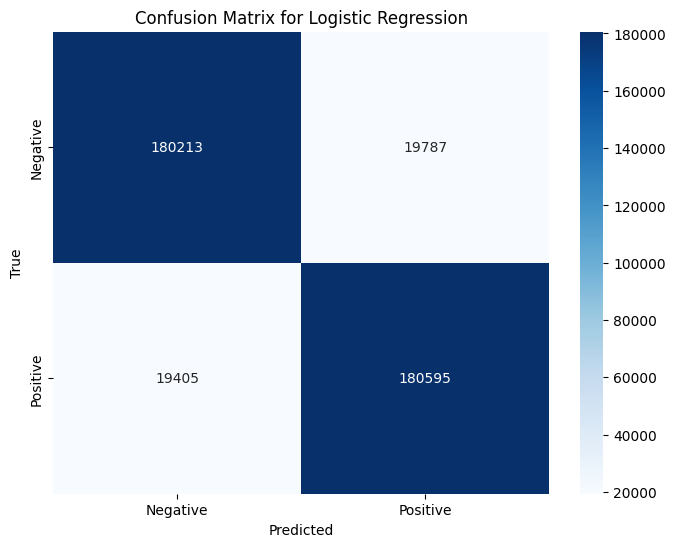

In [8]:

# List of classifiers to train (here we use Logistic Regression)
classifier = LogisticRegression(max_iter=1000)

# Define a Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and get accuracy for each fold
cv_scores = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validation results
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of CV Accuracy: {np.std(cv_scores):.4f}")

# Fit the model on the entire training set after cross-validation
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_test_pred = classifier.predict(X_test)

# Calculate accuracy on the test data
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}\n")
print(classification_report(y_test, y_test_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [9]:
import joblib

# Save the trained model to a file
model_filename = 'logistic_regression_model.pkl'
joblib.dump(classifier, model_filename)

print(f"Model saved as {model_filename}")


Model saved as logistic_regression_model.pkl
